In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_matrix(df, name="Matrix"):
    """
    df: DataFrame binario (genes × terms)
    name: Nome per il grafico
    """
    df = df.applymap(lambda x: 1 if x not in [0, "0", None] else 0)

    term_freq = df.sum(axis=0)

    print(f"\n=== ANALISI MATRICE: {name} ===")
    print(f"Numero geni (righe): {df.shape[0]}")
    print(f"Numero termini (colonne): {df.shape[1]}")
    print("\nPrimi valori della distribuzione:")
    print(term_freq.describe())

    plt.figure(figsize=(10, 5))
    plt.hist(term_freq, bins=50, alpha=0.8)
    plt.title(f"Distribuzione Frequenze dei Termini — {name}")
    plt.xlabel("Numero di geni annotati")
    plt.ylabel("Numero di termini")
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\n--- GUIDA ALLA SCELTA DEI TAGLI ---")
    print("• Termini molto rari = frequenza 1–2 → poco informativi")
    print("• Termini molto frequenti = top 10–20% → poco discriminativi")
    print("• Usa term_freq per definire una tua soglia:")
    print("\nEsempi possibili:")
    print(f"  - Taglio raro < 2 → {sum(term_freq < 2)} termini")
    print(f"  - Taglio raro < 3 → {sum(term_freq < 3)} termini")
    print(f"  - Taglio frequente > 10% → freq > {0.10 * df.shape[0]:.1f} = {sum(term_freq > 0.10 * df.shape[0])} termini")
    print(f"  - Taglio frequente > 20% → freq > {0.20 * df.shape[0]:.1f} = {sum(term_freq > 0.20 * df.shape[0])} termini")

    print("\nUsa term_freq per scegliere:")
    print("Esempio:  terms_to_drop = term_freq[term_freq < 3].index")

    return term_freq


C:\Users\gianl\AppData\Local\Temp\ipykernel_14840\794520014.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x not in [0, "0", None] else 0)



=== ANALISI MATRICE: MF ===
Numero geni (righe): 5183
Numero termini (colonne): 3258

Primi valori della distribuzione:
count    3258.000000
mean       21.614180
std       150.389016
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      5008.000000
dtype: float64


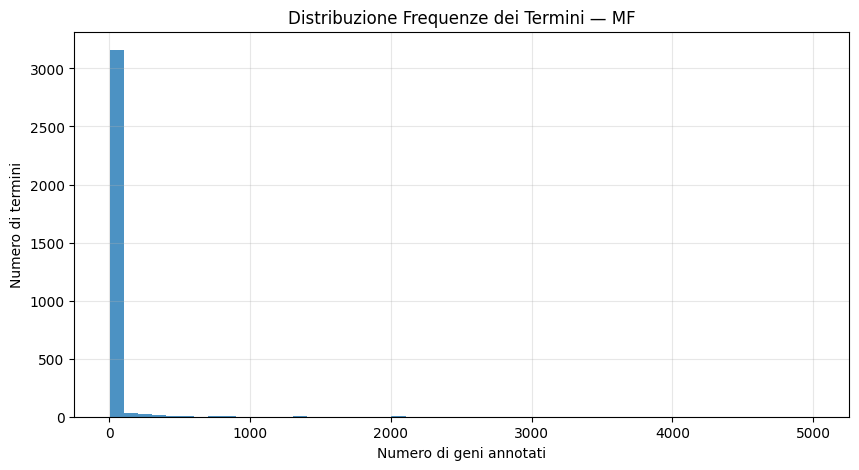


--- GUIDA ALLA SCELTA DEI TAGLI ---
• Termini molto rari = frequenza 1–2 → poco informativi
• Termini molto frequenti = top 10–20% → poco discriminativi
• Usa term_freq per definire una tua soglia:

Esempi possibili:
  - Taglio raro < 2 → 1355 termini
  - Taglio raro < 3 → 1843 termini
  - Taglio frequente > 10% → freq > 518.3 = 23 termini
  - Taglio frequente > 20% → freq > 1036.6 = 8 termini

Usa term_freq per scegliere:
Esempio:  terms_to_drop = term_freq[term_freq < 3].index


GO.0004060       1
GO.0005515    4282
GO.0000049      42
GO.0002161       9
GO.0002196       1
              ... 
GO.0035716       1
GO.0047349       1
GO.0070567       6
GO.0030624       1
GO.0030627       1
Length: 3258, dtype: int64

In [2]:

PATH_MF = "gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv"



df = pd.read_csv(PATH_MF, index_col=0)
analyze_matrix(df, "MF")

In [ ]:
import pandas as pd

def filter_terms_by_frequency(df, min_freq=2, max_prop=0.20, verbose=True):
    """
    Filtra le colonne (termini) di un DataFrame binario gene×term in base alla frequenza.
    
    Args:
      df: pd.DataFrame, righe = geni, colonne = termini; valori 0/1 o booleani
      min_freq: int, soglia minima (es. rimuovi termini con < min_freq geni annotati)
      max_prop: float, proporzione massima (es. rimuovi termini con > max_prop * n_geni)
      verbose: bool, se True stampa le info
    
    Returns:
      df_filtered: DataFrame con solo i termini che passano il filtro
      dropped: dict con liste dei termini rimossi {"rare": [...], "frequent": [...]}
    """


    df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)

    n_genes = df_bin.shape[0]
    term_freq = df_bin.sum(axis=0)


    max_freq = max_prop * n_genes


    rare_terms = term_freq[term_freq < min_freq].index.tolist()
    frequent_terms = term_freq[term_freq > max_freq].index.tolist()

    if verbose:
        print(f"Numero geni: {n_genes}")
        print(f"Numero termini originali: {df.shape[1]}")
        print(f"Termini troppo rari (< {min_freq}): {len(rare_terms)}")
        print(f"Termini troppo frequenti (> {max_prop*100:.1f}% = {max_freq:.1f} geni): {len(frequent_terms)}")
        print(f"Totale termini da rimuovere: {len(set(rare_terms + frequent_terms))}")

    
    terms_to_drop = set(rare_terms + frequent_terms)
    df_filtered = df_bin.drop(columns=terms_to_drop)

    if verbose:
        print(f"Terminati: rimangono {df_filtered.shape[1]} termini dopo il filtraggio")

    return df_filtered, {"rare": rare_terms, "frequent": frequent_terms}

In [4]:
bp_filtered, dropped = filter_terms_by_frequency(df, min_freq=3, max_prop=0.20)

C:\Users\gianl\AppData\Local\Temp\ipykernel_14840\1844570272.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df.applymap(lambda x: 1 if x not in [0, "0", None, False] else 0)


Numero geni: 5183
Numero termini originali: 3258
Termini troppo rari (< 3): 1843
Termini troppo frequenti (> 20.0% = 1036.6 geni): 8
Totale termini da rimuovere: 1851
Terminati: rimangono 1407 termini dopo il filtraggio


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

def jaccard_sparse(a_idx, b_idx):
    inter = len(np.intersect1d(a_idx, b_idx))
    union = len(a_idx) + len(b_idx) - inter
    return inter / union if union > 0 else 0

def remove_redundant_terms_sparse(df, threshold=0.9, size_tol=0.2):
    print("\n=== RIMOZIONE COLONNE RIDONDANTI ===")
    print("Converto in matrice sparse...")
    X = csr_matrix(df.values)

    cols = df.columns.to_list()
    nnz = np.diff(X.indptr)

    print("Pre-calcolo indice geni annotati per colonna...")
    col_indices = []
    XT = X.T.tocsr()
    for i in range(X.shape[1]):
        start, end = XT.indptr[i], XT.indptr[i+1]
        col_indices.append(XT.indices[start:end])

    to_drop = set()

    print("Inizio confronto Jaccard (scalabile)...")
    for i in range(len(cols)):
        if cols[i] in to_drop:
            continue

        a_idx = col_indices[i]
        a_size = len(a_idx)

        for j in range(i+1, len(cols)):
            if cols[j] in to_drop:
                continue

            b_idx = col_indices[j]
            b_size = len(b_idx)

            if abs(a_size - b_size) / max(a_size, b_size) > size_tol:
                continue

            jac = jaccard_sparse(a_idx, b_idx)
            if jac >= threshold:
                to_drop.add(cols[j])

        if i % 200 == 0:
            print(f"  → Processate {i}/{len(cols)} colonne...")

    print(f"Colonne ridondanti trovate: {len(to_drop)}")
    print(f"Colonne finali: {len(cols) - len(to_drop)}")

    return df.drop(columns=list(to_drop))

def remove_redundant_rows_sparse(df, threshold=0.9, size_tol=0.2):

    print("\n--- RIMOZIONE RIGHE REDONDANTI ---")
    row_nnz = df.sum(axis=1).values
    empty_rows = df.index[row_nnz == 0].tolist()

    if empty_rows:
        print(f"Righe vuote rimosse: {len(empty_rows)}")
        df = df.drop(index=empty_rows)

    X = csr_matrix(df.values)
    row_indices = []
    for i in range(X.shape[0]):
        start, end = X.indptr[i], X.indptr[i+1]
        row_indices.append(X.indices[start:end])

    rows = df.index.to_list()
    to_drop = set()
    kept = []

    print("Inizio confronto Jaccard tra righe...")

    for i in range(len(rows)):
        if rows[i] in to_drop:
            continue

        kept.append(rows[i])
        a_idx = row_indices[i]
        a_size = len(a_idx)

       
        if a_size == 0:
            to_drop.add(rows[i])
            continue

        for j in range(i+1, len(rows)):
            if rows[j] in to_drop:
                continue

            b_idx = row_indices[j]
            b_size = len(b_idx)

           
            if b_size == 0:
                to_drop.add(rows[j])
                continue

           
            if max(a_size, b_size) == 0:
                continue

          
            if abs(a_size - b_size) / max(a_size, b_size) > size_tol:
                continue

            jac = jaccard_sparse(a_idx, b_idx)

            if jac >= threshold:
                to_drop.add(rows[j])

        if i % 200 == 0:
            print(f"  → Processate {i}/{len(rows)} righe...")

    print(f"Righe ridondanti trovate: {len(to_drop)}")
    print(f"Righe finali: {len(rows) - len(to_drop)}")

    return df.drop(index=list(to_drop))


def remove_redundancy_both_axes(df, col_threshold=0.9, row_threshold=0.9,
                                size_tol=0.2):
    print("\n==============================")
    print(" AVVIO PIPELINE RIDONDANZA")
    print("==============================")

    df_clean = remove_redundant_terms_sparse(
        df, threshold=col_threshold, size_tol=size_tol
    )

    df_clean = remove_redundant_rows_sparse(
        df_clean, threshold=row_threshold, size_tol=size_tol
    )

    print("\n=== COMPLETATO ===")
    print(f"Dimensioni finali: {df_clean.shape[0]} geni × {df_clean.shape[1]} termini")

    return df_clean


In [ ]:
bp_no_redundancy = remove_redundancy_both_axes(
    bp_filtered,
    col_threshold=0.90,
    row_threshold=0.95,   
    size_tol=0.2
)


 AVVIO PIPELINE RIDONDANZA

=== RIMOZIONE COLONNE RIDONDANTI ===
Converto in matrice sparse...
Pre-calcolo indice geni annotati per colonna...
Inizio confronto Jaccard (scalabile)...
  → Processate 0/1407 colonne...
  → Processate 200/1407 colonne...
  → Processate 400/1407 colonne...
  → Processate 600/1407 colonne...
  → Processate 800/1407 colonne...
  → Processate 1000/1407 colonne...
  → Processate 1200/1407 colonne...
  → Processate 1400/1407 colonne...
Colonne ridondanti trovate: 70
Colonne finali: 1337

--- RIMOZIONE RIGHE REDONDANTI ---
Righe vuote rimosse: 569
Inizio confronto Jaccard tra righe...
  → Processate 0/4614 righe...
  → Processate 200/4614 righe...
  → Processate 400/4614 righe...
  → Processate 600/4614 righe...
  → Processate 800/4614 righe...
  → Processate 1000/4614 righe...
  → Processate 1200/4614 righe...
  → Processate 1400/4614 righe...
  → Processate 1600/4614 righe...
  → Processate 1800/4614 righe...
  → Processate 2200/4614 righe...
  → Processate 30

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

def apply_tfidf(df):
    """
    Applica TF-IDF a una matrice binaria GO/HPO mantenendo formato sparso.
    Stampa messaggi di feedback durante l'esecuzione.
    """
    print("=== STEP C: TF-IDF sui termini ===")

    print("→ Converto il DataFrame in matrice sparse CSR...")
    X = csr_matrix(df.values)
    n_genes, n_terms = X.shape
    print(f"   Matrice: {n_genes} geni × {n_terms} termini")

    print("→ Calcolo la frequenza (df_j) dei termini...")
    df_j = np.array(X.sum(axis=0)).ravel()
    print("   Fatto. Esempio frequenze:")
    print("   - min:", df_j.min(), " max:", df_j.max(), " median:", np.median(df_j))


    print("→ Calcolo IDF = log(N / df_j)...")
    idf = np.log(n_genes / df_j)
    print("   Fatto. Esempio valori IDF:")
    print("   - min:", idf.min(), " max:", idf.max(), " median:", np.median(idf))

    print("→ Applico i pesi TF-IDF alle colonne (sparse-safe)...")
    X_tfidf = X.multiply(idf)
    print("   Fatto. La matrice finale è ancora sparse.")
    print(f"   Formato: {X_tfidf.shape}, non-zero entries: {X_tfidf.nnz}")

    print("=== TF-IDF COMPLETATO ===\n")

    return X_tfidf, idf


In [8]:
X_tfidf, idf = apply_tfidf(bp_no_redundancy)


=== STEP C: TF-IDF sui termini ===
→ Converto il DataFrame in matrice sparse CSR...
   Matrice: 3578 geni × 1337 termini
→ Calcolo la frequenza (df_j) dei termini...
   Fatto. Esempio frequenze:
   - min: 1  max: 798  median: 7.0
→ Calcolo IDF = log(N / df_j)...
   Fatto. Esempio valori IDF:
   - min: 1.5004506666188557  max: 8.182559264068665  median: 6.236649115013352
→ Applico i pesi TF-IDF alle colonne (sparse-safe)...
   Fatto. La matrice finale è ancora sparse.
   Formato: (3578, 1337), non-zero entries: 36930
=== TF-IDF COMPLETATO ===



In [ ]:
import umap
import matplotlib.pyplot as plt

def run_umap(X_tfidf, n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42, plot=True):
    """
    Applica UMAP su matrice TF-IDF sparse e opzionalmente produce un plot 2D.
    Stampa feedback su dimensioni e avanzamento.
    """

    print("=== STEP D: RIDUZIONE DIMENSIONALE con UMAP ===")
    print(f"Input: matrice {X_tfidf.shape[0]} geni × {X_tfidf.shape[1]} termini")


    print(f"→ Configurazione UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )

    print("→ Fitting UMAP (potrebbe richiedere qualche minuto per dataset grandi)...")
    embedding = reducer.fit_transform(X_tfidf)
    print(f"   Fatto. Embedding shape: {embedding.shape}")


    if plot:
        print("→ Produco il plot 2D dell'embedding...")
        plt.figure(figsize=(8,6))
        plt.scatter(embedding[:,0], embedding[:,1], s=10, alpha=0.7)
        plt.title("UMAP embedding dei geni (TF-IDF)")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.grid(True)
        plt.show()

    print("=== UMAP COMPLETATO ===\n")
    return embedding


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== STEP D: RIDUZIONE DIMENSIONALE con UMAP ===
Input: matrice 3578 geni × 1337 termini
→ Configurazione UMAP: n_neighbors=15, min_dist=0.1, metric=cosine
→ Fitting UMAP (potrebbe richiedere qualche minuto per dataset grandi)...


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Fatto. Embedding shape: (3578, 2)
→ Produco il plot 2D dell'embedding...


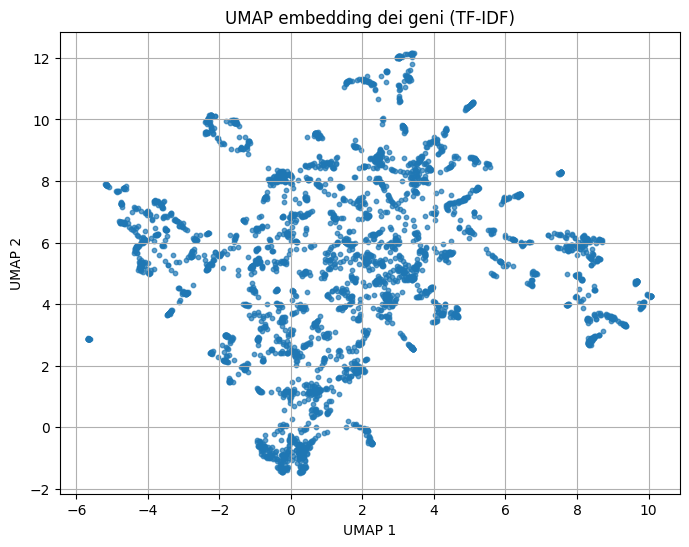

=== UMAP COMPLETATO ===



In [10]:
embedding = run_umap(X_tfidf, n_neighbors=15, min_dist=0.1, metric="cosine")


In [ ]:
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

def umap_hdbscan_plot(X_tfidf, gene_labels=None, n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42, interactive=True):
    """
    Pipeline: UMAP + HDBSCAN + plot (interattivo o matplotlib).
    
    Args:
        X_tfidf: matrice sparse TF-IDF (n_geni × n_terms)
        gene_labels: lista o pd.Series di annotazioni da usare come hover (opzionale)
        n_neighbors, min_dist, metric: parametri UMAP
        interactive: True -> plotly interattivo, False -> matplotlib statico
    
    Returns:
        embedding: np.array (n_geni × 2)
        cluster_labels: np.array dei cluster HDBSCAN
    """
    
    print("=== STEP D: UMAP embedding + HDBSCAN clustering ===")
    print(f"Input: {X_tfidf.shape[0]} geni × {X_tfidf.shape[1]} termini")
    

    print(f"→ Configuro UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    
    print("→ Fit e trasformazione UMAP...")
    embedding = reducer.fit_transform(X_tfidf)
    print(f"   Embedding shape: {embedding.shape}")
    
    print("→ Eseguo HDBSCAN sullo spazio UMAP...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
    cluster_labels = clusterer.fit_predict(embedding)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"   Cluster trovati: {n_clusters}, punti noise: {n_noise}")
    
    if interactive:
        print("→ Creo plot interattivo con Plotly...")
        df_plot = pd.DataFrame({
            'UMAP1': embedding[:,0],
            'UMAP2': embedding[:,1],
            'Cluster': cluster_labels.astype(str)
        })
        if gene_labels is not None:
            df_plot['Gene/Annotation'] = gene_labels
        
        fig = px.scatter(
            df_plot, x='UMAP1', y='UMAP2', color='Cluster',
            hover_data=['Gene/Annotation'] if gene_labels is not None else None,
            title='UMAP + HDBSCAN clustering',
            width=800, height=600
        )
        fig.show()
    else:
        print("→ Creo plot statico con Matplotlib...")
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(embedding[:,0], embedding[:,1], c=cluster_labels, cmap='tab20', s=10, alpha=0.7)
        plt.title("UMAP + HDBSCAN clustering")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True)
        plt.show()
    
    print("=== PIPELINE COMPLETATA ===\n")
    
    return embedding, cluster_labels


In [12]:
gene_labels = bp_no_redundancy.index  # nomi o ID dei geni
embedding, cluster_labels = umap_hdbscan_plot(
    X_tfidf,
    gene_labels=gene_labels,
    interactive=True
)


=== STEP D: UMAP embedding + HDBSCAN clustering ===
Input: 3578 geni × 1337 termini
→ Configuro UMAP: n_neighbors=30, min_dist=0.1, metric=cosine
→ Fit e trasformazione UMAP...


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Embedding shape: (3578, 2)
→ Eseguo HDBSCAN sullo spazio UMAP...
   Cluster trovati: 94, punti noise: 693
→ Creo plot interattivo con Plotly...


c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gianl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== PIPELINE COMPLETATA ===

